# Classification with _pipeline_
Show a pipeline of preprocessing and train/tune with _cross validation_

Use the public dataset __ionosphere__, last column is the target (binary)

Test two methods for __feature selection__
- [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) 
Select the `k` best feature according to a given __score function__
    - [`mutual_info_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)
    Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency
- [`RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) 
Select features by recursively considering smaller and smaller sets of features. It is used together with an estimator that returns the `feature_importances` of the features, such as
`DecisionTreeClassifier`,
`RandomForestClassifier`,
`GradientBoostingClassifier`,
`ExtraTreesClassifier`,
`AdaBoostClassifier`,
`XGBClassifier`,
`LGBMClassifier`


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from functools import partial

In [2]:
random_state=42
scoring = 'accuracy'
#scoring = 'roc_auc'
cv_folds = 5
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
df = pd.read_csv(url , sep = ',', header = None)
colnames = ['X'+str(i).zfill(2) for i in range(df.shape[1]-1)]
colnames.append('target')
df.columns = colnames
df.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,...,X25,X26,X27,X28,X29,X30,X31,X32,X33,target
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


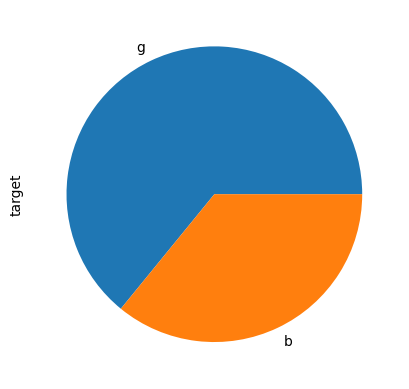

In [3]:
target = 'target'
df[target].value_counts().plot.pie();

In [4]:
X = df.drop(target, axis=1)
y = df[target]

In [5]:
# prepare the collection of scores
# scores = {}

In [6]:
cv = StratifiedKFold(n_splits=cv_folds
                     ,shuffle=True #Whether to shuffle each class’s samples 
                                     # before splitting into batches
                     ,random_state=random_state # for reproducibility
                    )

In [7]:
selector = RFE(DecisionTreeClassifier(criterion="entropy", random_state = random_state))
classifier = SVC(kernel='rbf', random_state=random_state)
estimator1 = DecisionTreeClassifier(random_state=random_state)
estimator2 = LogisticRegression()

In [8]:
pipe = Pipeline(steps=[("selector", selector), ("classifier", classifier)])
param_grid = {
    'selector__estimator':[estimator1,estimator2],
    'classifier__gamma':[1e-2, 1e-3, 1e-4],
    'classifier__C':[1, 10, 100, 500]
}
search = GridSearchCV(pipe, param_grid, cv=cv)
search.fit(X,y)

# scores['RFE+SVC'] = (search.best_params_, search.best_score_)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('selector',
                                        RFE(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                             random_state=42))),
                                       ('classifier', SVC(random_state=42))]),
             param_grid={'classifier__C': [1, 10, 100, 500],
                         'classifier__gamma': [0.01, 0.001, 0.0001],
                         'selector__estimator': [DecisionTreeClassifier(random_state=42),
                                                 LogisticRegression()]})

In [9]:
search.best_params_

{'classifier__C': 100,
 'classifier__gamma': 0.01,
 'selector__estimator': DecisionTreeClassifier(random_state=42)}

In [10]:
print("Best score {:4.2f}".format(search.best_score_))

Best score 0.94
